In [1]:
import spacy
import re
import textstat
import numpy as np
import pandas as pd
import sklearn.ensemble
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from nltk import WhitespaceTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

# Loading journal text entries

In [2]:
users = pd.read_csv('../data/users.csv')
journals = pd.read_csv('../data/journals.csv')

In [4]:
# Dropping NAN entries in sentiment/journal/date
journals_sub = journals.dropna(subset=['sentiment', 'journal', 'date'])
journals_sub['sentiment_level'] = journals_sub[[
    'sentiment'
]].apply(lambda x: pd.cut(x, [-np.inf, -.5, .5, np.inf],
                          labels=['negative', 'neutral', 'positive']))

/Users/afrah/miniconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Feature Engineering

In [ ]:
journals_sub['date'] = pd.to_datetime(journals_sub['date'])
journals_sub['year'] = pd.Series(journals_sub['date'].dt.year,
                                 dtype='category')
journals_sub['day'] = journals_sub['date'].dt.day_name()
journals_sub['month'] = journals_sub['date'].dt.month_name()
journals_sub['month_trans'] = np.cos(
    (journals_sub['date'].dt.month - 6.0) / 6.0)
journals_sub['timeofday'] = journals_sub['date'].dt.hour
journals_sub['timeofday_trans'] = np.cos(
    (journals_sub['date'].dt.hour - 12.0) / 12.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b7ada10>,
      dtype=object)

<Figure size 1080x576 with 0 Axes>

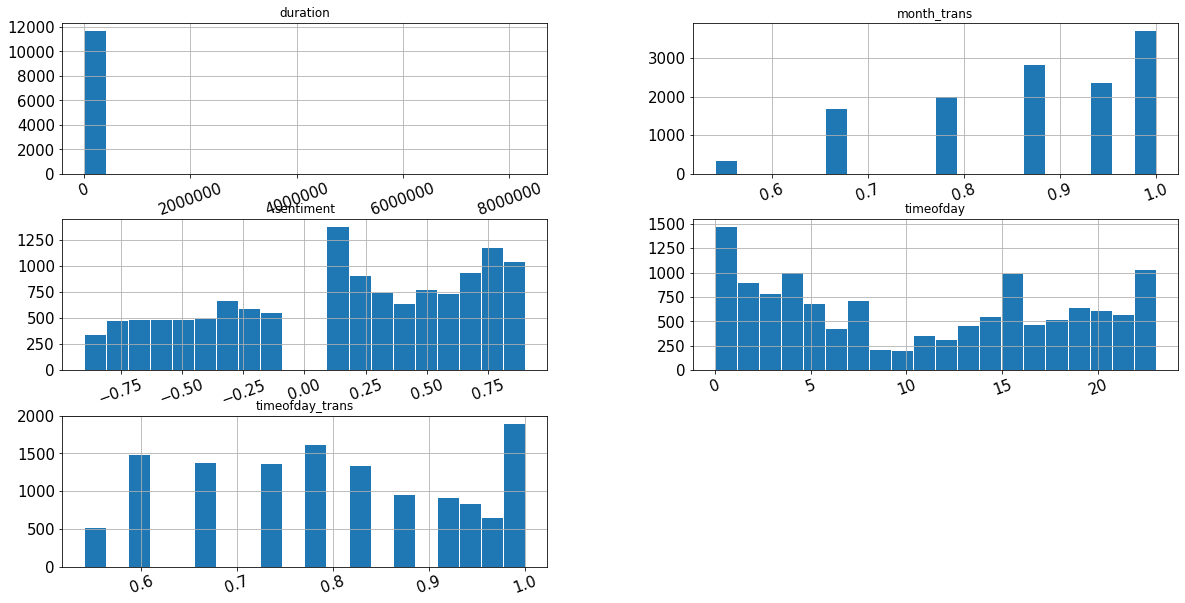

In [6]:
plt.figure(figsize=(15, 8))
journals_sub.hist(figsize=(20, 10),
                  ylabelsize=15,
                  xlabelsize=15,
                  xrot=20,
                  bins=20,
                  edgecolor='white')

To observe if there are any big fluctuations in sentiment levels across the years so that we can make reasonable assumptions about the distribution of the data.

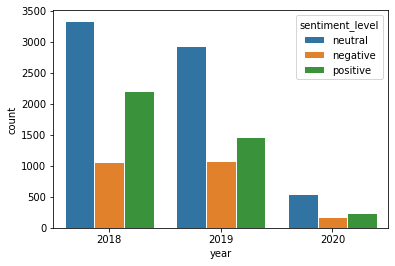

In [7]:
sns.countplot(x='year',
              hue='sentiment_level',
              data=journals_sub,
              orient='horizontal',
              edgecolor='white')

# Time of day effect on mood

This shows that numerous negative/positive entries are usually made at later/earlier hours in the day whereas neutral entries are made during mid-day. However as seen in the chart above the number of observations are also skewed between the different sentiment bins, which might indicate that "most entries" (and not sentiment-based associations) are made at earlier/later hours in the day rather than mid-day.

[Text(0, 0, 'neutral'), Text(0, 0, 'negative'), Text(0, 0, 'positive')]

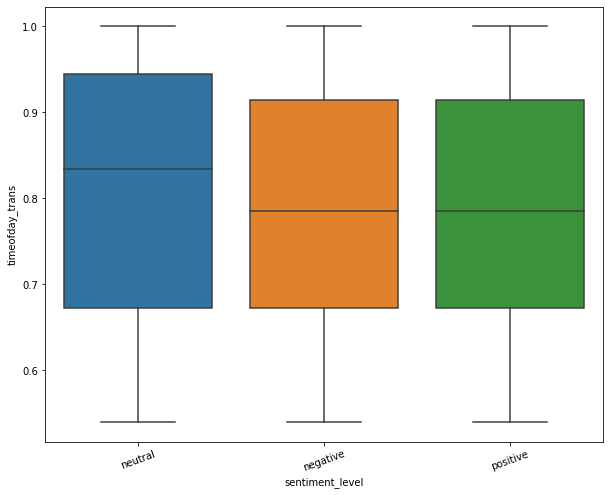

In [8]:
plt.figure(figsize=(10, 8))
# plt.subplot(2,2,1)
ax = sns.boxplot(x="sentiment_level", y='timeofday_trans', data=journals_sub)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

# plt.subplot(2,2,3)
# plt.scatter(x=np.arange(24), y= np.cos((np.arange(24)-12)/12))
# plt.axhline(y=0.75)

# Seasonal effect

Do Seasons influence mood predictions? Especially in the context of seasonal affective disorders

## Monthly fluctuations

This is an attempt to see if there is any seasonality effect on mood. A classic example is Seasonal Affective Disorders which might indicate more negative sentiment entries during Winter Season. When binning by month and using "continuous" sentiment scores, there is a "dip" around January and "peak" around May, which is an interesting observation. When using "continuous" month transformed variable (cosine-transformation) and binning by sentiment scores (neutral/positive/negative) this trend is less obvious.

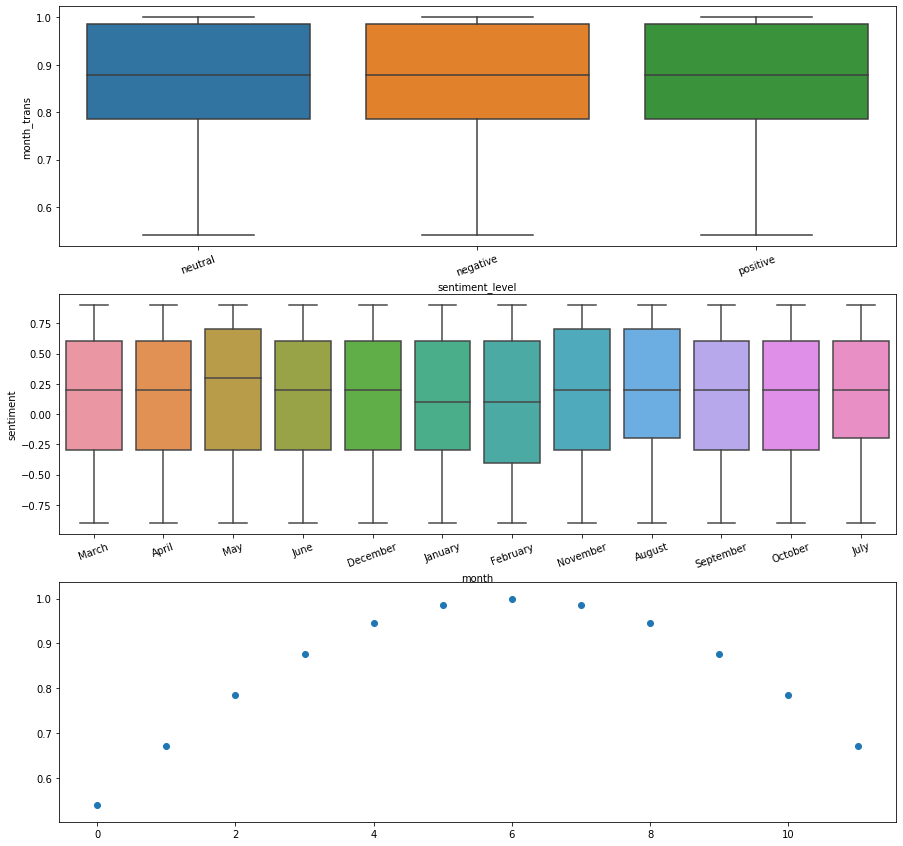

In [9]:
plt.figure(figsize=(15, 15))
plt.subplot(3, 1, 1)
ax = sns.boxplot(x="sentiment_level", y='month_trans', data=journals_sub)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.subplot(3, 1, 2)
ax = sns.boxplot(y="sentiment", x='month', data=journals_sub)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.subplot(3, 1, 3)
plt.scatter(x=np.arange(12), y=np.cos((np.arange(12) - 6) / 6))

## Seasonal fluctuations

In [10]:
Winter = ['December', 'January', 'February']
Spring = ['March', 'April', 'May']
Summer = ['June', 'July', 'August']
Fall = ['September', 'October', 'November']

seasons = dict(
    zip(Winter + Spring + Summer + Fall,
        ['Winter'] * 3 + ['Spring'] * 3 + ['Summer'] * 3 + ['Fall'] * 3))
journals_sub['season'] = journals_sub['month'].map(seasons)

seasons_color = dict(
    zip(Winter + Spring + Summer + Fall,
        ['skyblue'] * 3 + ['lightgreen'] * 3 + ['#FFD43B'] * 3 + ['Red'] * 3))

/Users/afrah/miniconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Winter seems to have the lowest mood predictions; though the difference compared to other seasons seems not too big of an effect. This impact may be masked by the clumping of months together and seems more evident in the monthly binning of sentiment scores above.

[Text(0, 0, 'Spring'),
 Text(0, 0, 'Summer'),
 Text(0, 0, 'Winter'),
 Text(0, 0, 'Fall')]

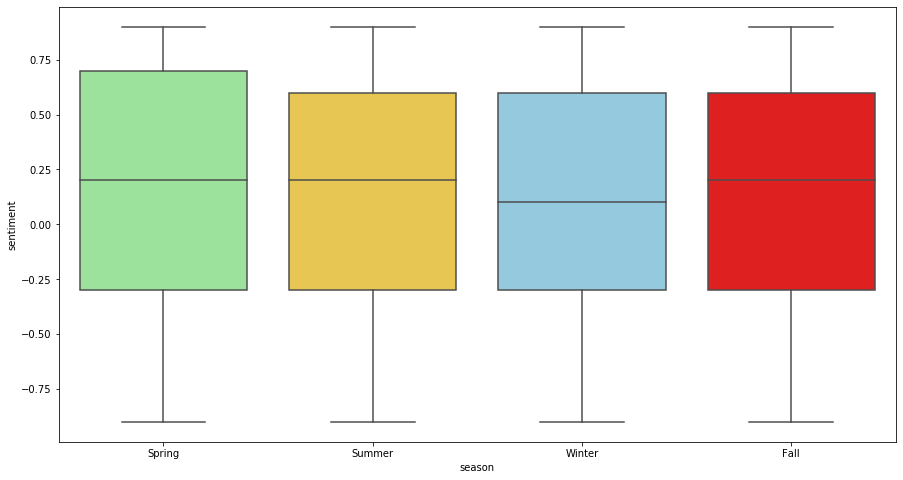

In [11]:
plt.figure(figsize=(15, 8))
ax = sns.boxplot(y="sentiment",
                 x='season',
                 data=journals_sub,
                 palette={
                     'Winter': 'skyblue',
                     'Fall': 'Red',
                     'Spring': 'lightgreen',
                     'Summer': '#FFD43B'
                 })
ax.set_xticklabels(ax.get_xticklabels())

# Content-based features

## Personal and Non-personal pronouns

This is to test the hypothesis that usage of pronouns might differ depending on mood where people may talk about themselves more often or less compared to other people depending on their mood/personality.

In [12]:
def get_pprn(doc):
    inner_pprn = ('i', 'me', 'my', 'mine', 'myself')
    outer_pprn = ('we', 'you', 'your', 'yourself', 'yours', 'yourselves', 'he',
                  'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
                  'they', 'them', 'their', 'theirs', 'themselves')
    inner_count = 0
    outer_count = 0

    for token in doc:
        if token.text in inner_pprn:
            inner_count += 1
        elif token.text in outer_pprn:
            outer_count += 1
    return inner_count, outer_count

These is a lot of variation in the length of the journal entry where longer journal entries are observed less often than shorter journal entries

/Users/afrah/miniconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0, '# Words in Entry')

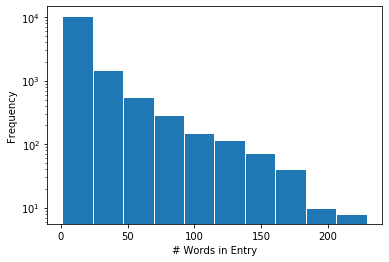

In [13]:
journals_sub['word_len'] = journals_sub['journal'].apply(lambda x: len(x.split(' ')))
journals_sub['word_len'].plot(kind='hist', logy=True, edgecolor='white')

# print(sum(journals_sub['word_len']>50))
plt.xlabel('# Words in Entry')

In [14]:
nlp = spacy.load("en_core_web_sm")
i_count_all = []
o_count_all = []

for entry in journals_sub['journal']:
    doc = nlp(entry.lower())
    i_count, o_count = get_pprn(doc)
    i_count_all.append(i_count)
    o_count_all.append(o_count)

In [ ]:
journals_sub['inner_pprn'] = np.array(i_count_all)
journals_sub['outer_pprn'] = np.array(o_count_all)
journals_sub[
    'sum_pprn'] = journals_sub['outer_pprn'] + journals_sub['inner_pprn']
journals_sub[
    'inner_frac'] = journals_sub['inner_pprn'] / journals_sub['sum_pprn']
journals_sub['inner_frac'] = journals_sub['inner_frac'].fillna(0)
journals_sub[
    'outer_frac'] = journals_sub['outer_pprn'] / journals_sub['sum_pprn']
journals_sub['outer_frac'] = journals_sub['outer_frac'].fillna(0)
journals_sub['pprn_ratio'] = np.array(i_count_all) / (np.array(o_count_all) +
                                                      1)

This figure shows that there is an association between sentiment, total pronouns used and the ratio of pronouns used to describe self vs. pronouns used to describe others (PPRN/Personal Pronoun Ratio Numeric). 

You can see this teased apart using the measure (Number of I,Me used/Total personal pronouns) where positive sentiments are seen more when this fraction is higher i.e. when people use alot of personal pronouns and when people talk about themselves more the sentiment is more positive.

Text(0.5, 0, '')

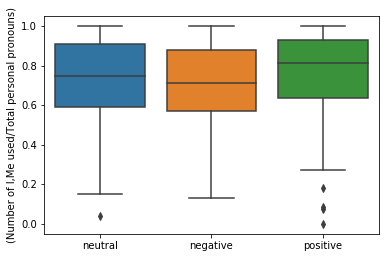

In [49]:
sns.boxplot(x='sentiment_level',
            y='inner_frac',
            data=journals_sub[journals_sub['sum_pprn'] > 10])
plt.ylabel('(Number of I,Me used/Total personal pronouns)')
plt.xlabel('')

This effect is also there when looking at ratio of pronouns used to describe self vs. pronouns used to describe others (PPRN/Personal Pronoun Ratio Numeric). When we threshold the journal entries that use at least 10 personal pronouns and bin sentiment scores, the median PPRN is higher for positive journal entries

Text(0.5, 0, '')

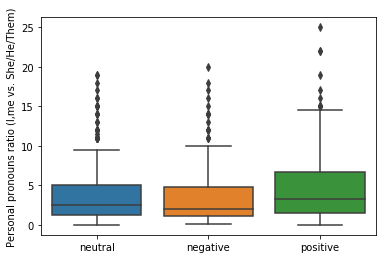

In [50]:
sns.boxplot(x='sentiment_level',
            y='pprn_ratio',
            data=journals_sub[journals_sub['sum_pprn'] > 10])
plt.ylabel('Personal pronouns ratio (I,me vs. She/He/Them)')
plt.xlabel('')

In [18]:
stop_words = set(stopwords.words('english'))

filtered_sentences = journals_sub['journal'].apply(
    lambda x: ' '.join([i for i in WhitespaceTokenizer().tokenize(x)]))

In [19]:
corpus = journals_sub['journal']
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'),
                             token_pattern=r'(?u)\b[A-Za-z]+\b')
mat = vectorizer.fit_transform(corpus)

## Readability scores

This effect of sentiment can also be observed using polysyllable count where people with positive sentiment scores tend to use more difficult/long polysyllable count words compared to those with negative sentiments.

In [ ]:
journals_sub['polysyllable_count'] = journals_sub['journal'].apply(
    lambda x: textstat.textstat.polysyllabcount(x))
journals_sub['difficult_words'] = journals_sub['journal'].apply(
    lambda x: textstat.textstat.difficult_words(x))
journals_sub['cl_index'] = journals_sub['journal'].apply(
    lambda x: textstat.textstat.coleman_liau_index(x))

Text(0.5, 0, '')

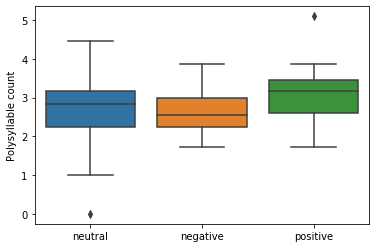

In [37]:
sns.boxplot(x='sentiment_level',
            y=np.sqrt(journals_sub[journals_sub.sum_pprn>20].polysyllable_count),         
            data=journals_sub)
plt.ylabel('Polysyllable count')
plt.xlabel('')

## Users-frequency of posting

There is also user behavior element in predictions where some users have logged more entries than others. For this analysis we dont have access to how long the user has been using the app which may be a contributing factor for this. Here we try to see what the median sentiment score looks like for users that log more journal entries than others.

In [ ]:
journals_sub['user'] = journals_sub['path'].apply(
    lambda x: re.sub('"', '',
                     x.split(',')[1].strip()))

Text(0, 0.5, '# Users')

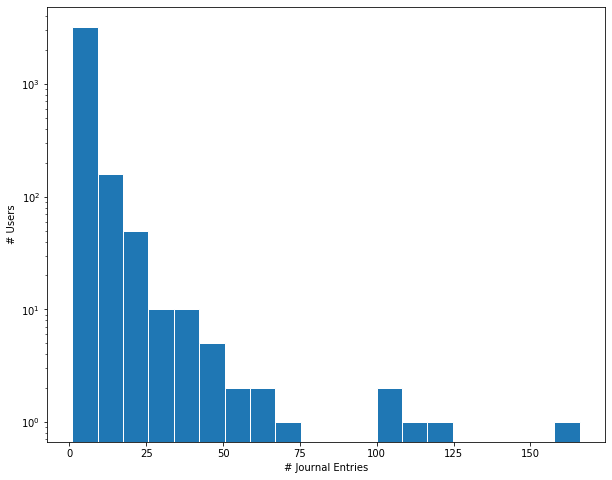

In [23]:
# Number of journal entries varies per user
plt.figure(figsize=(10, 8))
plt.hist(journals_sub['user'].value_counts(), bins=20, edgecolor='white')
plt.yscale('log')
plt.xlabel('# Journal Entries')
plt.ylabel('# Users')

As seen, the higher the number of entries by a user, the higher the median sentiment score of these journal entries. This can be due to (i) 'happier' users tend to log more entries/use the app more, (ii) users tend to be happier the longer they use the app, or (iii) sentiment scores are unreliable and these associations dont show any meaningful signals.

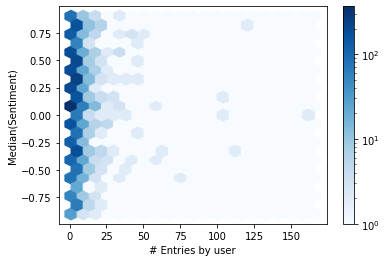

In [26]:
# Variance in sentiment scores may also be associated with # entries by a user
plt.hexbin(y=journals_sub.groupby('user').median()['sentiment'],
           x=journals_sub['user'].value_counts(),
           gridsize=20,
           cmap='Blues',
           bins='log')
plt.xlabel('# Entries by user')
plt.ylabel('Median(Sentiment)')
plt.colorbar()